
## ✅ Summary of the Task

**Goal**: Given a sequence of discrete 6D word vectors (representing an unknown language), predict whether the **next word will increase or decrease the sentiment** of the sentence.

---

## 🧱 Step-by-Step Plan

### 1. **Synthetic Dataset Creation**

* Build a vocabulary of discrete 6D word vectors.
* Define a simple but meaningful **sentiment function** over sequences (e.g., a non-linear function of vector mean or weighted sum).
* For each sequence, compute sentiment before and after adding the next word → label: `↑` or `↓`.

### 2. **Input Preprocessing**

Since vectors are discrete:

* Normalize: ✅ (to remove scale issues).
* Quantize: ❌ probably not needed unless you're feeding integer tokens. Transformers work better with continuous embeddings.

So: **normalize the vectors (e.g., MinMax or z-score)**, but don’t quantize yet — we’re not tokenizing.

### 3. **Model Architecture**

* Transformer encoder for the **sequence** of vectors.
* Final vector (to be predicted) can be:

  * Appended (and let the model learn the delta)
  * OR input separately and compared with sentence encoding

**Output**: Binary classification (↑ or ↓ in sentiment)

---


In [1]:
import jupyter

C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import gymnasium as gym
import matplotlib.pyplot as plt


from src.utils.system import boot
from src.defaults import RANDOM_SEEDS, TOP2_STOCK_BY_SECTOR
from tracker import OHLCV_DF, EpisodeTracker, EnvironmentTracker, AgentTracker

In [13]:
df = OHLCV_DF[OHLCV_DF['symbol']=="AAPL"].copy()
df = df.set_index('date')[['open','high','low','close','volume','trade_count','sp500','vix', 'return_1d',]]

df['candle_size'] = df['high'] - df['low']
df['candle_relative_size'] = df['candle_size'] / df['open']

df['candle_upper'] = (df['high'] - np.maximum(df['open'], df['close'])) / df['candle_size']
df['candle_body'] = np.abs(df['close'] - df['open']) / df['candle_size']
df['candle_lower'] = (np.minimum(df['open'], df['close']) - df['low']) / df['candle_size']

df['candle_direction'] = np.sign(df['close'] - df['open'])
df

,open,high,low,close,volume,trade_count,sp500,vix,return_1d,candle_size,candle_relative_size,candle_upper,candle_body,candle_lower,candle_direction
date,,,,,,,,,,,,,,,
2022-01-04,182.640,182.94,179.120,179.70,106090378.0,831898.0,47.9354,0.1691,-0.026600,3.820,0.020915,0.078534,0.769634,0.151832,-1.0
2022-01-05,179.610,180.17,174.640,174.92,95142198.0,848518.0,47.0058,0.1973,-0.026600,5.530,0.030789,0.101266,0.848101,0.050633,-1.0
2022-01-06,172.700,175.30,171.640,172.00,103899632.0,960344.0,46.9605,0.1961,-0.016693,3.660,0.021193,0.710383,0.191257,0.098361,-1.0
2022-01-07,172.890,174.14,171.030,172.17,94554334.0,715419.0,46.7703,0.1876,0.000988,3.110,0.017988,0.401929,0.231511,0.366559,-1.0
2022-01-10,169.080,172.50,168.170,172.19,117005143.0,956342.0,46.7029,0.1940,0.000116,4.330,0.025609,0.071594,0.718245,0.210162,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-29,203.575,203.81,198.510,199.95,51477938.0,652509.0,59.1217,0.1918,-0.002345,5.300,0.026035,0.044340,0.683962,0.271698,-1.0
2025-05-30,199.370,201.96,196.780,200.85,70819942.0,605924.0,59.1169,0.1857,0.004501,5.180,0.025982,0.214286,0.285714,0.500000,1.0
2025-06-02,200.280,202.13,200.120,201.70,35423294.0,501431.0,59.3594,0.1836,0.004232,2.010,0.010036,0.213930,0.706468,0.079602,1.0


In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Simulated OHLCV-like dataframe (for demonstration)
np.random.seed(42)


# Feature engineering
df['candle_size'] = df['high'] - df['low']
df['candle_relative_size'] = df['candle_size'] / df['open']
df['candle_upper'] = (df['high'] - np.maximum(df['open'], df['close'])) / df['candle_size']
df['candle_body'] = np.abs(df['close'] - df['open']) / df['candle_size']
df['candle_lower'] = (np.minimum(df['open'], df['close']) - df['low']) / df['candle_size']
df['candle_direction'] = np.sign(df['close'] - df['open'])

# Drop rows with NaN
df = df.dropna()

# Select 6D word vector features
vector_cols = [
    'candle_relative_size',
    'candle_upper',
    'candle_body',
    'candle_lower',
    'candle_direction',
    'return_1d'
]

# Normalize the features
scaler = StandardScaler()
df[vector_cols] = scaler.fit_transform(df[vector_cols])

# Preview the normalized vector-based dataset
import ace_tools_open as tools; tools.display_dataframe_to_user(name="Normalized Candle Vector Dataset", dataframe=df[vector_cols].head(20))


Normalized Candle Vector Dataset


Loading ITables v2.4.0 from the internet... (need help?)


In [15]:
import torch
from torch.utils.data import Dataset

class SentimentShiftDataset(Dataset):
    def __init__(self, df, sequence_length=10):
        self.sequence_length = sequence_length
        self.vector_cols = [
            'candle_relative_size',
            'candle_upper',
            'candle_body',
            'candle_lower',
            'candle_direction',
            'return_1d'
        ]
        self.data = df[self.vector_cols].values
        self.labels = (df['return_1d'].shift(-1) > 0).astype(int).values  # 1 if next return is positive
        self.valid_indices = range(len(df) - sequence_length - 1)

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        start_idx = self.valid_indices[idx]
        end_idx = start_idx + self.sequence_length
        sequence = self.data[start_idx:end_idx]
        label = self.labels[end_idx]  # Label is based on return of the day after the sequence
        return torch.tensor(sequence, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [16]:
dataset = SentimentShiftDataset(df, sequence_length=10)

# Get one sample
x, y = dataset[0]
print("Input shape:", x.shape)   # (10, 6)
print("Label:", y.item())        # 0 or 1


Input shape: torch.Size([10, 6])
Label: 0


In [26]:
import torch.nn as nn
import torch.nn.functional as F

class TransformerSentimentClassifier(nn.Module):
    def __init__(self, input_dim=6, model_dim=32, num_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.model_dim = model_dim

        # Input projection to model_dim
        self.input_proj = nn.Linear(input_dim, model_dim)

        # Learnable positional encoding
        self.pos_encoding = nn.Parameter(torch.randn(1, 100, model_dim))  # max_len=100

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification head
        self.cls_head = nn.Sequential(
            nn.Linear(model_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # Binary classification (↑ / ↓)
        )

    def forward(self, x):
        """
        x: (batch_size, seq_len, input_dim)
        """
        batch_size, seq_len, _ = x.size()

        # Project input to model_dim
        x = self.input_proj(x)

        # Add positional encoding
        x = x + self.pos_encoding[:, :seq_len, :]

        # Transformer expects (seq_len, batch_size, model_dim)
        x = x.permute(1, 0, 2)

        # Transformer Encoder
        x = self.transformer_encoder(x)

        # Use the last token (or mean pooling)
        x = x[-1, :, :]  # (batch_size, model_dim)

        # Classify
        out = self.cls_head(x)  # (batch_size, 2)
        return out


In [35]:
class TransformerSentimentClassifier(nn.Module):
    def __init__(self, input_dim=6, model_dim=32, num_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.model_dim = model_dim
        self.input_proj = nn.Linear(input_dim, model_dim)
        self.pos_encoding = nn.Parameter(torch.randn(1, 100, model_dim))  # max_len=100

        # Define the encoder layer
        self.encoder_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True)
            for _ in range(num_layers)
        ])
        self.encoder = nn.Sequential(*self.encoder_layers)

        self.cls_head = nn.Sequential(
            nn.Linear(model_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x, return_attention=False):
        x = self.input_proj(x)  # (B, T, D)
        x = x + self.pos_encoding[:, :x.size(1), :]

        attentions = []

        for layer in self.encoder_layers:
            # Hook into attention weights via forward pre-hook
            def hook(module, input, output):
                attn = module.self_attn(input[0], input[0], input[0])[1]
                attentions.append(attn.detach().cpu())

            handle = layer.register_forward_hook(hook)
            x = layer(x)
            handle.remove()

        cls_out = x[:, -1, :]  # use the last token
        logits = self.cls_head(cls_out)

        if return_attention:
            return logits, attentions
        return logits


In [36]:
from torch.utils.data import DataLoader, random_split
import torch

# Instantiate dataset
dataset = SentimentShiftDataset(df, sequence_length=10)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Initialize model
model = TransformerSentimentClassifier()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
def train(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                output = model(batch_x)
                preds = output.argmax(dim=1)
                correct += (preds == batch_y).sum().item()
                total += batch_y.size(0)
        accuracy = correct / total
        print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Val Acc: {accuracy:.4f}")


In [ ]:
train(model,train_loader,val_loader,optimizer,criterion,epochs=100)

Epoch 1 | Loss: 0.6543 | Val Acc: 0.5000
Epoch 2 | Loss: 0.6593 | Val Acc: 0.5176
Epoch 3 | Loss: 0.6443 | Val Acc: 0.4824
Epoch 4 | Loss: 0.6464 | Val Acc: 0.5059
Epoch 5 | Loss: 0.6351 | Val Acc: 0.5235


In [41]:
def evaluate_model(model, dataloader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            logits = model(batch_x)
            preds = logits.argmax(dim=1)
            correct += (preds == batch_y).sum().item()
            total += batch_y.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    accuracy = correct / total
    print(f"[✓] Held-Out Accuracy: {accuracy:.4f}")
    return all_preds, all_labels

In [42]:
preds,labels=evaluate_model(model,val_loader)

[✓] Held-Out Accuracy: 0.5059


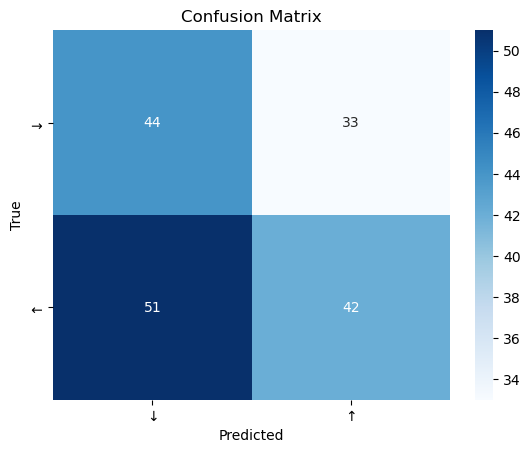

              precision    recall  f1-score   support

           ↓       0.46      0.57      0.51        77
           ↑       0.56      0.45      0.50        93

    accuracy                           0.51       170
   macro avg       0.51      0.51      0.51       170
weighted avg       0.52      0.51      0.51       170



In [43]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["↓", "↑"], yticklabels=["↓", "↑"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(labels, preds, target_names=["↓", "↑"]))